# Machine Learning Part 1

## Linear Analysis
In this part, we use machine learning to get a model to determine likelyhood of side effects.

In [76]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from config import apikey
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import json

In [77]:
# Get json obtained from database
vae_df = pd.read_json("https://vae-watcher.herokuapp.com/api")
#vae_df = vae_df.drop(columns="_id")
vae_df.head()

,AGE_YRS,ALLERGIES,BIRTH_DEFECT,COUNT_SYMPTOM,CUR_ILL,DATEDIED,DIED,DISABLE,ER_ED_VISIT,ER_VISIT,...,VAERS_ID,VAX_DATE,VAX_DOSE_SERIES,VAX_LOT,VAX_MANU,VAX_NAME,VAX_ROUTE,VAX_SITE,VAX_TYPE,X_STAY
0,33.0,Pcn and bee venom,No,2,None,Alive,False,No,No,No,...,916600,12/28/2020,1,037K20A,MODERNA,COVID19 (COVID19 (MODERNA)),IM,LA,COVID19,No
1,73.0,"""""""Dairy""""""",No,2,Patient residing at nursing facility. See pati...,Alive,False,No,No,No,...,916601,12/31/2020,1,025L20A,MODERNA,COVID19 (COVID19 (MODERNA)),IM,RA,COVID19,No
2,23.0,Shellfish,No,4,None,Alive,False,No,Yes,No,...,916602,12/31/2020,1,EL1284,PFIZER\BIONTECH,COVID19 (COVID19 (PFIZER-BIONTECH)),IM,LA,COVID19,No
3,58.0,"Diclofenac, novacaine, lidocaine, pickles, tom...",No,3,kidney infection,Alive,False,No,No,No,...,916603,12/23/2020,UNK,unknown,MODERNA,COVID19 (COVID19 (MODERNA)),0,0,COVID19,No
4,47.0,Na,No,4,None,Alive,False,No,No,No,...,916604,12/22/2020,1,0,MODERNA,COVID19 (COVID19 (MODERNA)),IM,LA,COVID19,No


In [78]:
#Get column names
print(vae_df.columns)

Index(['AGE_YRS', 'ALLERGIES', 'BIRTH_DEFECT', 'COUNT_SYMPTOM', 'CUR_ILL',
       'DATEDIED', 'DIED', 'DISABLE', 'ER_ED_VISIT', 'ER_VISIT', 'HISTORY',
       'HOSPDAYS', 'HOSPITAL', 'LAB_DATA', 'LATITUDE', 'LONGITUDE', 'L_THREAT',
       'NUMDAYS', 'OFC_VISIT', 'ONSET_DATE', 'OTHER_MEDS', 'PRIOR_VAX',
       'RECOVD', 'RECVDATE', 'SEX', 'STATE', 'STATE_NAME', 'SYMPTOM1',
       'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5', 'SYMPTOM_TEXT',
       'VAERS_ID', 'VAX_DATE', 'VAX_DOSE_SERIES', 'VAX_LOT', 'VAX_MANU',
       'VAX_NAME', 'VAX_ROUTE', 'VAX_SITE', 'VAX_TYPE', 'X_STAY'],
      dtype='object')


In [79]:
# Create column with number of VAEs per patient
sympcounts = []
for index, row in vae_df.iterrows():
    counter = 0
    columns = ["SYMPTOM1","SYMPTOM2","SYMPTOM3","SYMPTOM4","SYMPTOM5"]
    for column in columns:
        if row[column] != "None":
            counter = counter + 1
    sympcounts.append(counter)
vae_df["SYMPTOM_COUNT"] = sympcounts
vae_df.head()

,AGE_YRS,ALLERGIES,BIRTH_DEFECT,COUNT_SYMPTOM,CUR_ILL,DATEDIED,DIED,DISABLE,ER_ED_VISIT,ER_VISIT,...,VAX_DATE,VAX_DOSE_SERIES,VAX_LOT,VAX_MANU,VAX_NAME,VAX_ROUTE,VAX_SITE,VAX_TYPE,X_STAY,SYMPTOM_COUNT
0,33.0,Pcn and bee venom,No,2,None,Alive,False,No,No,No,...,12/28/2020,1,037K20A,MODERNA,COVID19 (COVID19 (MODERNA)),IM,LA,COVID19,No,2
1,73.0,"""""""Dairy""""""",No,2,Patient residing at nursing facility. See pati...,Alive,False,No,No,No,...,12/31/2020,1,025L20A,MODERNA,COVID19 (COVID19 (MODERNA)),IM,RA,COVID19,No,2
2,23.0,Shellfish,No,4,None,Alive,False,No,Yes,No,...,12/31/2020,1,EL1284,PFIZER\BIONTECH,COVID19 (COVID19 (PFIZER-BIONTECH)),IM,LA,COVID19,No,4
3,58.0,"Diclofenac, novacaine, lidocaine, pickles, tom...",No,3,kidney infection,Alive,False,No,No,No,...,12/23/2020,UNK,unknown,MODERNA,COVID19 (COVID19 (MODERNA)),0,0,COVID19,No,3
4,47.0,Na,No,4,None,Alive,False,No,No,No,...,12/22/2020,1,0,MODERNA,COVID19 (COVID19 (MODERNA)),IM,LA,COVID19,No,4


### Analysis 1: Age Vs. Severity of Reaction (Number of Symptoms)

In [80]:
# Get values for age and severity, clean data from outliers
clean = vae_df[vae_df["VAX_TYPE"]=="COVID19"]
agesev_df = pd.DataFrame(clean[["AGE_YRS","SYMPTOM_COUNT"]])
agesev_df["AGE_YRS"].replace('', np.nan, inplace=True)
agesev_df.dropna(subset=['AGE_YRS'], inplace=True)
agesev_df["AGE_YRS"] = pd.to_numeric(agesev_df["AGE_YRS"])
agesev_df = agesev_df[agesev_df["AGE_YRS"]>=18]
agesev_df = agesev_df[agesev_df["AGE_YRS"]<=100]
agesev_df = agesev_df.groupby(["AGE_YRS"], as_index=False).mean()
df1 = agesev_df
agesev_df.head()

,AGE_YRS,SYMPTOM_COUNT
0,18.0,3.428571
1,19.0,3.812500
2,20.0,3.740385
3,21.0,3.622047
4,22.0,3.731844


In [81]:
# Define as X and Y
X = agesev_df.AGE_YRS.to_list()
y = agesev_df.SYMPTOM_COUNT.to_list()

In [82]:
# Create model
X = agesev_df.AGE_YRS.values.reshape(-1, 1)
y = agesev_df.SYMPTOM_COUNT.values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
print('Weight coefficients: ', model.coef_[0][0])
print('y-axis intercept: ', model.intercept_[0])

Weight coefficients:  -0.006996950253310058
y-axis intercept:  3.9643731998017033


In [83]:
# Create equation for plotting
slope1 = model.coef_[0][0]
intcp1 = model.intercept_[0]
equation1 = slope1 * X + intcp1

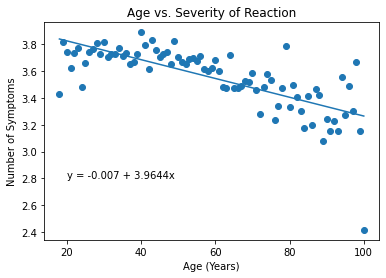

In [84]:
# Plot data
line_eq1 = f"y = {round(model.coef_[0][0],4)} + {round(model.intercept_[0],4)}x"
plt.scatter(X, y)
plt.plot(X,equation1)
plt.title('Age vs. Severity of Reaction')
plt.xlabel('Age (Years)')
plt.ylabel('Number of Symptoms')
plt.annotate(line_eq1,(20,2.8),fontsize=10,color="black")
plt.show()

### Analysis 2: Age Vs. Severity of Reaction (Number of Symptoms) - Pfizer

In [85]:
# Get values for age and severity, clean data from outliers
clean = vae_df[vae_df["VAX_NAME"]=="COVID19 (COVID19 (PFIZER-BIONTECH))"]
agesev_df = pd.DataFrame(clean[["AGE_YRS","SYMPTOM_COUNT"]])
agesev_df["AGE_YRS"].replace('', np.nan, inplace=True)
agesev_df.dropna(subset=['AGE_YRS'], inplace=True)
agesev_df["AGE_YRS"] = pd.to_numeric(agesev_df["AGE_YRS"])
agesev_df = agesev_df[agesev_df["AGE_YRS"]>=18]
agesev_df = agesev_df[agesev_df["AGE_YRS"]<=100]
agesev_df = agesev_df.groupby(["AGE_YRS"], as_index=False).mean()
df2 = agesev_df
agesev_df.head()

,AGE_YRS,SYMPTOM_COUNT
0,18.0,3.388889
1,19.0,3.407407
2,20.0,3.731707
3,21.0,3.571429
4,22.0,3.541176


In [86]:
# Define as X and Y
X = agesev_df.AGE_YRS.to_list()
y = agesev_df.SYMPTOM_COUNT.to_list()

In [87]:
# Create model
X = agesev_df.AGE_YRS.values.reshape(-1, 1)
y = agesev_df.SYMPTOM_COUNT.values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
print('Weight coefficients: ', model.coef_[0][0])
print('y-axis intercept: ', model.intercept_[0])

Weight coefficients:  -0.003029302505273373
y-axis intercept:  3.7313784836912673


In [88]:
# Create equation for plotting
slope1 = model.coef_[0][0]
intcp1 = model.intercept_[0]
equation1 = slope1 * X + intcp1

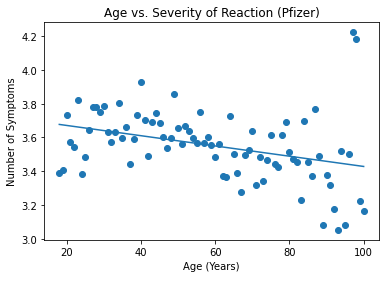

In [89]:
# Plot data
line_eq2 = f"y = {round(model.coef_[0][0],4)} + {round(model.intercept_[0],4)}x"
plt.scatter(X, y)
plt.plot(X,equation1)
plt.title('Age vs. Severity of Reaction (Pfizer)')
plt.xlabel('Age (Years)')
plt.ylabel('Number of Symptoms')
plt.annotate(line_eq2,(20,2.8),fontsize=10,color="black")
plt.show()

### Analysis 3: Age Vs. Severity of Reaction (Number of Symptoms) - Moderna

In [90]:
# Get values for age and severity, clean data from outliers
clean = vae_df[vae_df["VAX_NAME"]=="COVID19 (COVID19 (MODERNA))"]
agesev_df = pd.DataFrame(clean[["AGE_YRS","SYMPTOM_COUNT"]])
agesev_df["AGE_YRS"].replace('', np.nan, inplace=True)
agesev_df.dropna(subset=['AGE_YRS'], inplace=True)
agesev_df["AGE_YRS"] = pd.to_numeric(agesev_df["AGE_YRS"])
agesev_df = agesev_df[agesev_df["AGE_YRS"]>=18]
agesev_df = agesev_df[agesev_df["AGE_YRS"]<=100]
agesev_df = agesev_df.groupby(["AGE_YRS"], as_index=False).mean()
df3 = agesev_df
agesev_df.head()

,AGE_YRS,SYMPTOM_COUNT
0,18.0,3.437500
1,19.0,4.071429
2,20.0,3.698113
3,21.0,3.564516
4,22.0,3.847059


In [91]:
# Define as X and Y
X = agesev_df.AGE_YRS.to_list()
y = agesev_df.SYMPTOM_COUNT.to_list()

In [92]:
# Create model
X = agesev_df.AGE_YRS.values.reshape(-1, 1)
y = agesev_df.SYMPTOM_COUNT.values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
print('Weight coefficients: ', model.coef_[0][0])
print('y-axis intercept: ', model.intercept_[0])

Weight coefficients:  -0.009712223122316425
y-axis intercept:  4.11046846990723


In [93]:
# Create equation for plotting
slope1 = model.coef_[0][0]
intcp1 = model.intercept_[0]
equation1 = slope1 * X + intcp1

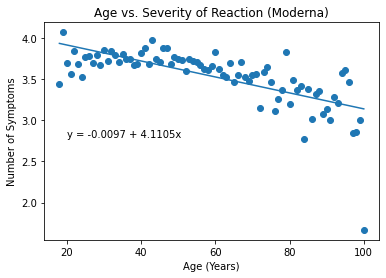

In [94]:
# Plot data
line_eq2 = f"y = {round(model.coef_[0][0],4)} + {round(model.intercept_[0],4)}x"
plt.scatter(X, y)
plt.plot(X,equation1)
plt.title('Age vs. Severity of Reaction (Moderna)')
plt.xlabel('Age (Years)')
plt.ylabel('Number of Symptoms')
plt.annotate(line_eq2,(20,2.8),fontsize=10,color="black")
plt.show()

### Analysis 4: Age Vs. Deaths

In [95]:
# Get values for age and severity, clean data from outliers
clean = vae_df[vae_df["VAX_TYPE"]=="COVID19"]
ageded_df = pd.DataFrame(clean[["AGE_YRS","DIED"]])
ageded_df["AGE_YRS"].replace('', np.nan, inplace=True)
ageded_df.dropna(subset=['AGE_YRS'], inplace=True)
ageded_df["AGE_YRS"] = pd.to_numeric(ageded_df["AGE_YRS"])
ageded_df = ageded_df[ageded_df["AGE_YRS"]>=18]
ageded_df = ageded_df[ageded_df["AGE_YRS"]<=100]
ageded_df = ageded_df[ageded_df["DIED"]==True]
ageded_df = ageded_df.groupby(["AGE_YRS"], as_index=False).count()
df4 = ageded_df
ageded_df.head()

,AGE_YRS,DIED
0,18.0,2
1,22.0,1
2,23.0,2
3,25.0,2
4,28.0,5


In [96]:
# Define as X and Y
X = ageded_df.AGE_YRS.to_list()
y = ageded_df.DIED.to_list()

In [97]:
# Create model
X = ageded_df.AGE_YRS.values.reshape(-1, 1)
y = ageded_df.DIED.values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
print('Weight coefficients: ', model.coef_[0][0])
print('y-axis intercept: ', model.intercept_[0])

Weight coefficients:  0.5421864155055189
y-axis intercept:  -15.092456956064208


In [98]:
# Create equation for plotting
slope1 = model.coef_[0][0]
intcp1 = model.intercept_[0]
equation1 = slope1 * X + intcp1

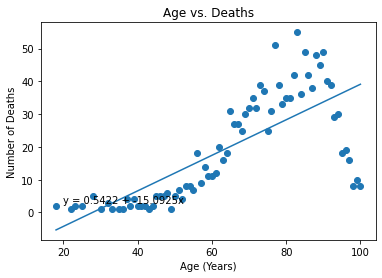

In [99]:
# Plot data
line_eq2 = f"y = {round(model.coef_[0][0],4)} + {round(model.intercept_[0],4)}x"
plt.scatter(X, y)
plt.plot(X,equation1)
plt.title('Age vs. Deaths')
plt.xlabel('Age (Years)')
plt.ylabel('Number of Deaths')
plt.annotate(line_eq2,(20,2.8),fontsize=10,color="black")
plt.show()

### Analysis 5: Common Symptoms

In [100]:
# Get all symptoms in a list
sym1 = vae_df.SYMPTOM1.dropna().to_list()
sym2 = vae_df.SYMPTOM2.dropna().to_list()
sym3 = vae_df.SYMPTOM3.dropna().to_list()
sym4 = vae_df.SYMPTOM4.dropna().to_list()
sym5 = vae_df.SYMPTOM5.dropna().to_list()
syms = sym1 + sym2 + sym3 + sym4 + sym5

In [101]:
# Get value counts
unique_ids = []
for x in syms:
    if x not in unique_ids:
        unique_ids.append(x)
counts = []
for sym in unique_ids:
    a = syms.count(sym)
    counts.append(a)
sym_df = pd.DataFrame({'Symptoms': unique_ids, 'Count': counts})
sym_df = sym_df.sort_values(["Count"],ascending=False)
sym_df = sym_df.drop(1528)
sym_df = sym_df.reset_index(drop=True)
sym_df.head()

,Symptoms,Count
0,None,33867
1,Headache,4782
2,Chills,4391
3,Fatigue,3673
4,Pain,2528


In [102]:
# Get stats
percents = []
sumsym = vae_df["VAERS_ID"].count()
for index, row in sym_df.iterrows():
        d = (row["Count"]/sumsym)*100
        percents.append(f"{round(d,2)}%")
sym_df["Percent"] =  percents
sym_df.head()

,Symptoms,Count,Percent
0,None,33867,137.93%
1,Headache,4782,19.48%
2,Chills,4391,17.88%
3,Fatigue,3673,14.96%
4,Pain,2528,10.3%


In [103]:
# Get top 10
top10df = sym_df.nlargest(10, 'Count')
top10df

,Symptoms,Count,Percent
0,None,33867,137.93%
1,Headache,4782,19.48%
2,Chills,4391,17.88%
3,Fatigue,3673,14.96%
4,Pain,2528,10.3%
5,Dizziness,2499,10.18%
6,Pyrexia,2409,9.81%
7,Nausea,2075,8.45%
8,Injection site pain,1920,7.82%
9,Injection site erythema,1836,7.48%


### Comparison With Total Vaccination

In [104]:
# Get state names
st = vae_df.STATE.to_list()
unique_states = []
for x in st:
    if x not in unique_states:
        unique_states.append(x)

In [105]:
# Get covid data from states
response = requests.get(f"https://api.covidactnow.org/v2/states.json?apiKey={apikey}")
r = response.json()

In [106]:
# Get DataFrame
clean = vae_df[vae_df["VAX_TYPE"]=="COVID19"]
vacc = pd.DataFrame(clean[["STATE","SYMPTOM_COUNT"]])
vacc.STATE.dropna()
vacc = vacc.groupby(["STATE"],as_index=False).count()
vacc = vacc.drop(0)
vacc.head()

,STATE,SYMPTOM_COUNT
1,AL,242
2,AR,242
3,AZ,541
4,CA,2199
5,CO,557


In [107]:
# Get vaccination numbers
vacc = vacc.drop([7])
vaxlist = []
statelist = vacc["STATE"].to_list()
for i in range(len(r)):
    stateab = r[i]["state"]
    if stateab in statelist:
        vaxlist.append(r[i]["actuals"]["vaccinesAdministered"])
vacc["TOTALVAX"] = vaxlist
vacc = vacc.reset_index(drop=True)
vacc.head()

,STATE,SYMPTOM_COUNT,TOTALVAX
0,AL,242,3988529
1,AR,242,2745701
2,AZ,541,7489034
3,CA,2199,47513370
4,CO,557,6754208


In [108]:
# Get percentages
pcnts = []
for index, row in vacc.iterrows():
    f = (row["SYMPTOM_COUNT"]/row["TOTALVAX"])*100
    pcnts.append(f"{round(f,6)}%")
vacc["PERCENT"] = pcnts 
vacc = vacc.rename(columns={"SYMPTOM_COUNT": "VAES_REPORTED"})
vacc.head()

,STATE,VAES_REPORTED,TOTALVAX,PERCENT
0,AL,242,3988529,0.006067%
1,AR,242,2745701,0.008814%
2,AZ,541,7489034,0.007224%
3,CA,2199,47513370,0.004628%
4,CO,557,6754208,0.008247%


### Get Dictionary and JSON

In [113]:
# Create dictionary
vaedict = {
  "agesymptomsall": df1.to_dict('index'),
  "agesymptomspfizer": df2.to_dict('index'),
  "agesymptomsmoderna": df3.to_dict('index'),
  "top10symptoms": top10df.to_dict('index'),
  "totalvaccines": vacc.to_dict('index')
}

In [114]:
# Display dictionary
vaedict

{'agesymptomsall': {0: {'AGE_YRS': 18.0, 'SYMPTOM_COUNT': 3.4285714285714284},
  1: {'AGE_YRS': 19.0, 'SYMPTOM_COUNT': 3.8125},
  2: {'AGE_YRS': 20.0, 'SYMPTOM_COUNT': 3.7403846153846154},
  3: {'AGE_YRS': 21.0, 'SYMPTOM_COUNT': 3.622047244094488},
  4: {'AGE_YRS': 22.0, 'SYMPTOM_COUNT': 3.7318435754189943},
  5: {'AGE_YRS': 23.0, 'SYMPTOM_COUNT': 3.773399014778325},
  6: {'AGE_YRS': 24.0, 'SYMPTOM_COUNT': 3.4834710743801653},
  7: {'AGE_YRS': 25.0, 'SYMPTOM_COUNT': 3.658536585365854},
  8: {'AGE_YRS': 26.0, 'SYMPTOM_COUNT': 3.7409470752089136},
  9: {'AGE_YRS': 27.0, 'SYMPTOM_COUNT': 3.761764705882353},
  10: {'AGE_YRS': 28.0, 'SYMPTOM_COUNT': 3.808457711442786},
  11: {'AGE_YRS': 29.0, 'SYMPTOM_COUNT': 3.7231920199501247},
  12: {'AGE_YRS': 30.0, 'SYMPTOM_COUNT': 3.815347721822542},
  13: {'AGE_YRS': 31.0, 'SYMPTOM_COUNT': 3.7044967880085653},
  14: {'AGE_YRS': 32.0, 'SYMPTOM_COUNT': 3.7288135593220337},
  15: {'AGE_YRS': 33.0, 'SYMPTOM_COUNT': 3.729847494553377},
  16: {'AGE_YRS': 3

In [112]:
# Get json
with open('../data.json', 'w') as fp:
    json.dump(vaedict, fp)